# Logistic Regression via Gradient Descent

In [ ]:
%matplotlib inline

import sys
import os
import time
import datetime
import json

import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Command-line args

nepochs = 1001
learnrate = 0.01
verbosity = 0
Verbosity = verbosity

train_points_filename = 'train_blobpoints.txt'
test_points_filename = 'test_blobpoints.txt'
plot_filename = '_logisticregression.png'

examples_dir = '/Users/jay/github/ml-examples'
data_dir = os.path.join(examples_dir, 'data')
train_points_path = os.path.join(data_dir, train_points_filename)
test_points_path = os.path.join(data_dir, test_points_filename)

This notebook shows how to implement logistic regression via gradient descent 
to classify a set of 2D points. Each point has a class label 0 or 1. Let:

$X = $ the set of 2D points (each with coordinates $(x_0, x_1)$

$Y = $ the set of class labels for each point in $X$

We implement a class called LogisticRegressionModel to compute the best-fit decision surface
to classify the points in $X$. 
That is, this model finds parameters to enable it to with high accuracy classify each point in $X$ correctly.

To do this we define a cost function for this classification task and using gradient descent minimize the cost function by modifying the parameters of the model.

In particular, let:

$m = $ number of points  
$W = $ weights of the logistic regression model (a vector)<br>
$b = $ bias of the model

To compute the output for the model for any input vector $X$ we first compute the weighted sum of that vector $X$ with the weight vector $W$ and bias $b$

$$Z = WX + b$$

In logistic regression we typically use a sigmoid nonlinearity to compute the activation vector $A$ from
the weighted sum $Z$:

$$A = g(Z) = \frac{1}{1 + e^{-Z}}$$

For a classification task we typically use the cross-entropy loss function:

$$\mathscr{L} = -(y\ln{(A)} + (1 - y)\ln{(1 - A)})$$

The total cost $J$ is the average of the losses $\mathscr{L}$ over all training exemplars:

$$ J = \frac{1}{m} \sum_{i=1}^{m} \mathscr{L}^{(i)} $$

We want chose $W$ and $b$ to minimize cost $J$:

So let's work backwards from the loss.
The derivative of $\mathscr{L}$ with respect to $A$ is:

$$\frac{\partial \mathscr{L}}{\partial A} = \frac{-y}{a} + \frac{(1-y)}{(1-a)}$$

Then we compute the partials of $A$ with respect to $Z$:

$$ \frac{\partial A}{\partial Z} = a(1 - a) $$

So:

$$\begin{align}
\frac{\partial \mathscr{L}}{\partial Z} & =  \frac{\partial \mathscr{L}}{\partial A} \frac{\partial A}{\partial Z} \\
& = -(\frac{y}{a} - \frac{(1 - y)}{(1 - 1)}) a(1 - a) \\
& = -y + a \\
& = a - y 
\end{align} $$


Then we compute the partials of $Z$ with respect to $W$ and $b$:
$$\frac{\partial Z}{\partial W} = X$$
$$\frac{\partial Z}{\partial b} = 1$$

We then use the chain rule to get what we need: the partials of the loss $\mathscr{L}$ with repect to $W$ and $b$:

$$ \frac{\partial \mathscr{L}}{\partial W} = \frac{\partial \mathscr{L}}{\partial Z} \frac{\partial Z}{\partial w} = x(A - y)$$
$$ \frac{\partial \mathscr{L}}{\partial b} = \frac{d \mathscr{L}}{\partial Z} \frac{\partial Z}{\partial b} = (A - y)$$

To compute the gradients with respect to the overall cost $J$ we simply average across the losses for each point in the set:

$$\frac{\partial J}{\partial W} = \frac{1}{m} \sum_{i=1}^{m} x^{(i)}(A^{(i)} - y^{(i)})$$

$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (A^{(i)} - y^{(i)})$$

These gradients point in the direction of increasing cost $J$. So to decrease the cost, we move $W$ and $b$ a small amount in the opposite directions of the gradients. Let:

$\alpha = $ learning rate, typically a small number like $0.001$

We modify $W$ and $b$ with these equations:

$$W = W - \alpha \frac{\partial J}{\partial W}$$

$$b = b - \alpha \frac{\partial J}{\partial b}$$

We see this implemented in the __fit()__ function for the `LogisticRegressionModelVectorized` class below.


### What we want:

After we have trained a model, we want it to have learned a line with slope and intercept so that it is a very good decision surface for this task. That is, most points are classified correctly. Here is an example of a set of points and the logistic regression line that minimizes the cost function. We want this:


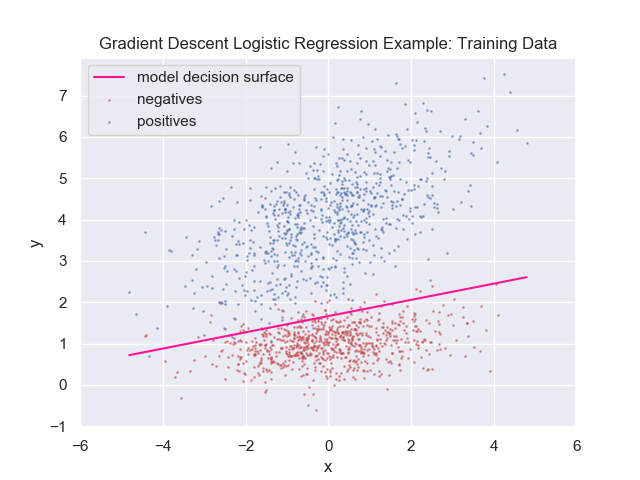

## Code for logistic regression

In [ ]:
def read_points_file(fname, delim=','):
    """
    Read x y points from a text file, returning numpy arrays containing the x,y coordinates and the target label.

    The file contains one row for each training example (m examples).
    The first field holds the target label for the example.
    The remaining fields hold the coordinates of the input vector. For this example,
    these are 2D points on the x0, x1 plane.
    We return two arrays: one for the x coordinate vectors and one for the label y values.
    The x ndarray has one column for each training example and 2 rows.
    The y ndarray has one column for each training example and 1 row.

    :param fname: Name of file holding the input and target data for training.
    :type fname: string
    :param delim: Delimiter between fields in the text file
    :type delim: one character string
    :return x: ndarray of input vectors
    :rtype x: ndarray of floats of shape (2, m)
    :rtype labels: ndarray of ints of shape (1, m)
    """
    dat1 = np.loadtxt(fname, delimiter=delim)
    m = dat1.shape[0]
    assert dat1.shape[1] >= 3

    labels = dat1[:, 0].reshape(1, m)
    labels = labels.astype(int)
    xrows = dat1[:, 1:]
    xs = xrows.T

    # We'll also need the positives and the negatives split out eventually,
    # so let's do that now.

    xneg = dat1[dat1[:, 0] < 0.01][:, 1:]
    xpos = dat1[dat1[:, 0] > 0.01][:, 1:]

    return xs, labels, xneg, xpos

### Code for the logistic regression model

In [ ]:
class LogisticRegressionModel:
    """
    Class used to implement logistic regression model.

    Attributes:
        coef_ : linear model coefficients
        intercept_ : linear model intercept
        cost_: model cost wrt training data
        thresh_: Threshold on activation to decide whether output y^hat is 0 or 1
        train_accuracy_: Accuracy measured on training set
        train_recall_: Recall measured on training set
        train_precision_: Precision measured on training set
        test_accuracy_: Accuracy measured on test set
        test_recall_: Recall measured on test set
        test_precision_: Precision measured on test set
        train_stats_: List of tuples of key training metrics, one tuple every 100 epochs

    """

    def __init__(self, winit=[0.01, 0.01], intercept=0.0):
        """

        :param winit: list of floats, optional
            Initial value of the weights
        :param intercept: float, optional
            Initial value of intercept
        """

        self.pos_label_ = 1
        self.neg_label_ = 0
        self.coef_ = np.array(winit).reshape(1, -1)
        self.coef_ = self.coef_.T
        self.intercept_ = intercept
        self.nx_ = self.coef_.shape[0]
        self.trainset_count_ = 0
        self.thresh_ = 0.5
        self.early_stop_cost_delta = 0.0001
        self.cost_ = 0.0
        self.r2_score_ = None
        self.modeltraintimestr_ = None
        self.train_accuracy_ = None
        self.train_recall_ = None
        self.train_precision_ = None
        self.test_accuracy_ = None
        self.test_recall_ = None
        self.test_precision_ = None
        self.train_stats_ = []

    def write(self, filename):
        """
        Write model attributes to file.


        :param filename: name of output file.
        :type filename: string
        :return: None
        """
        # Put the fields we want to persist into a dictionary.
        w = self.coef_.ravel().tolist()    # flatten the weight vector for writing.
        out_dict = {}
        out_dict['trainset_count'] = self.trainset_count_
        out_dict['feature_count'] = self.nx_
        out_dict['train_datetime'] = self.modeltraintimestr_
        out_dict['train_cost'] = self.cost_
        out_dict['train_accuracy'] = self.train_accuracy_
        out_dict['train_recall'] = self.train_recall_
        out_dict['train_precision'] = self.train_precision_
        out_dict['test_accuracy'] = self.test_accuracy_
        out_dict['test_recall'] = self.test_recall_
        out_dict['test_precision'] = self.test_precision_
        out_dict['intercept'] = self.intercept_
        out_dict['weights'] = w

        with open(filename, 'w') as json_file:
            json.dump(out_dict, json_file, indent=4, sort_keys=True)

    def write_training_stats(self, filename):
        """
        Write training statistics to file.

        These include the epoch, cost, training accuracy, recall and precision, and the model weights.
        Also plots the model cost on the training data as a function of epoch.
        :param filename: Statistics filename
        :type filename: string
        :return: None
        """
        train_stats_df = pd.DataFrame(data=self.train_stats_,
                                      columns=['epoch', 'cost', 'accuracy', 'recall', 'precision', 'b', 'w0', 'w1'])
        train_stats_df.to_csv(filename, index=False)

        # Plot cost as a function of training epoch.
        print('Training statistics head:')
        print(train_stats_df.head(20))
        max_df = train_stats_df.max(axis=0)
        max_cost = max_df['cost']
        max_cost = max_cost if max_cost > 0.1 else 0.1
        print('max_cost: {}'.format(max_cost))
        plt.figure()
        sns.set(style='darkgrid')
        ax = sns.lineplot(x='epoch', y='cost', data=train_stats_df)
        ax.set(xlabel='Epoch', ylabel='Cost', title='Regression Model Training Cost')
        ax.set_ylim(0.0, 1.1 * max_cost)
        plt.savefig('_logisticregressionmodel_train_cost.png')
        plt.close()

    def compute_decision_surface(self):
        """
        Using the model weights and intercept b, compute the slope and y intercept
        of the decision surface of the model, which is a line for the 2D x inputs
        of this example code.
        :return slope: The slope of the decision surface line
        :rtype slope: float
        :return intercept: The y intercept of the decision surface line
        :rtype intercept: float
        """
        # Decision surface is a line s.t.
        # w0 * x0 + w1 * x1 + b = 0
        # or, to compute the slope and intercept of that line:
        # x1 = -(w0/w1)*x0 - b/w1

        w = self.coef_.ravel()
        b = self.intercept_

        slope = -(w[0] / w[1])
        y_intercept = -(b / w[1])
        return slope, y_intercept

    def predict_proba(self, x):
        """
        Compute the activation A for the model given an input vectors x.

        This activation is the probability for that input x that it is
        in the positive class. Ie, the probability that the prediction
        for x should be 1.
        :param x: input which is a set of m 2D column vectors stacked horizontally
        :type x: ndarrary of floats of shape (nx, m)
        :return A: Activation matrix, one column for each column of x
        :rtype A: ndarray of floats of shape (nx, m)
        """
        w = self.coef_
        b = self.intercept_

        # A couple parameter validity checks...
        assert (w.shape[0] == 2)
        assert (x.shape[1] >= 1)
        assert (x.shape[0] == w.shape[0])

        # Compute z = wx + b
        Z = np.dot(w.T, x) + b

        # Compute activation (or yhat)
        A = 1.0 / (1.0 + np.exp(-Z))
        return A

    def predict(self, x):
        """
        Compute the class for each exemplar vector in x

        :param x: numpy array of floats of shape (nx, m)
            The input feature vectors to run the model on.
        :return y_pred: The class prediction for each vector in x
        :rtype y_pred: ndarray of int of shape (1, m)
        """
        # ToDo: Set threshold to value s.t. FP rate == FN rate
        a = self.predict_proba(x)
        y_pred = (a >= self.thresh_)
        y_pred = y_pred.astype(int)
        return y_pred

    @staticmethod
    def summary_metrics(y_true, y_pred):
        """
        Compute most useful summary metrics: accuracy, recall and precision.

        :param y_true: The target or label value for a data exemplar.
        :type y_true: numpy array of ints of shape (1, m)
        :param y_pred: The class label predicted by the model.
        :type y_pred: numpy array of ints of shape (1, m)
        :return accuracy: The accuracy of the predictions.
        :rtype accuracy: float
        :return recall: The recall of the predictions.
        :rtype recall: float
        :return precision: The precision of the predictions.
        :rtype precision: float
        """

        ny = y_true.size
        n_pos = y_true.sum()
        n_neg = ny - n_pos
        accuracy = sklearn.metrics.accuracy_score(y_true.ravel(), y_pred.ravel())
        recall = sklearn.metrics.recall_score(y_true.ravel(), y_pred.ravel())
        precision = sklearn.metrics.precision_score(y_true.ravel(), y_pred.ravel())
        if Verbosity > 0:
            sys.stderr.write('# Positives: {}\t# Negatives: {}'.format(n_pos, n_neg))
            sys.stderr.write('Accuracy: {}\tRecall: {}\tPrecision: {}'.format(accuracy, recall, precision))
        return accuracy, recall, precision
    
    def fit(self, xs, ys, nepochs=10, learnrate=0.01):
        """Computes slope and intercept of best fit line for points.

        Trying the numpy docstring format here.

        Parameters
        ----------
        xs : numpy array of shape (m,) floats where m is the number of points
            The x coordinates of the points
        ys : numpy array of shape (m,) floats
            The y coordinates of the points
        nepochs : int
            Number of training epochs
        learnrate : float
            Learning rate

        Action 
        Computes the slope and interecept of the best-fit line for a set of points
        and put those into coef_[0][0] and intercept_ , respectively.
        """

        # A couple checks on the parameters:
        # The xs and ys must be the same length
        assert(xs.shape[1] == ys.shape[1])
        # We need to run for at least 1 epoch
        assert(nepochs > 0)

        w = self.coef_
        b = self.intercept_

        accuracy = 0.0
        recall = 0.0
        precision = 0.0

        # How often to print training stats.
        training_stats_interval = 100
        if nepochs < 100:
            training_stats_interval = 10
        elif nepochs > 80000:
            training_stats_interval = 1000

        # We'll need the number of points a lot:
        m = ys.size
        self.trainset_count_ = m

        # The mean of the y values will be used for evaluating the model.
        y_mean = ys.mean()

        if Verbosity > 0:
            sys.stderr.write('m: {}\n'.format(m))
            sys.stderr.write('y_mean: {}\n'.format(y_mean))
            sys.stderr.write('Initial w {}\n'.format(w))
            sys.stderr.write('Initial b {}\n'.format(b))

        J = 999999999.0
        J_last = J
        J_delta_avg = J
        lowpass_alpha = 0.1
        early_stopping_cost_delta_threshold = 0.0001

        total_train_time = 0.0
        t0 = time.perf_counter()

        for epoch in range(nepochs):
            t0 = time.perf_counter()

            # Compute cost J and gradients at each epoch

            # Compute z = wx + b
            Z = np.dot(w.T, xs) + b

            # Compute activation (or yhat)
            A = 1.0 / (1.0 + np.exp(-Z))
            y_pred = (A >= self.thresh_)
            y_pred = y_pred.astype(int)
            if Verbosity > 1:
                print('A:')
                print(A)
                print('A.shape: {}'.format(A.shape))
                print('ys.shape: {}'.format(ys.shape))

            sys.stdout.flush()
            sys.stderr.flush()

            # Compute cost
            # Use cross entropy loss
            J_all = -1.0 * ((ys * np.log(A)) + (1.0 - ys) * np.log(1.0 - A))
            J = J_all.sum() / m

            # Compute gradients
            dz = (A - ys)
            dw = np.dot(xs, dz.T) / m
            db = np.sum(dz) / m
            if Verbosity > 1:
                print('J_all: {}'.format(J_all))
                print('J: {}'.format(J))
                print('dz: {}'.format(dz))
                print('db: {}'.format(db))
                print('dw: {}'.format(dw))

            # Update weights
            w -= learnrate * dw
            b -= learnrate * db

            t1 = time.perf_counter()
            total_train_time += t1 - t0

            if (epoch % training_stats_interval) == 0:
                # sys.stderr.write('\ndw: {}\n'.format(dw))
                # sys.stderr.write('db: {}\n'.format(db))
                sys.stdout.flush()
                sys.stderr.write('\nepoch: {}\tcost: {:.6f}\tb: {:.4f}\tw: {}\n'.format(epoch, J, b, w))
                if epoch == 0:
                    J_delta_avg = J
                else:
                    accuracy, recall, precision = LogisticRegressionModel.summary_metrics(ys, y_pred)
                    w_flat = w.ravel()
                    self.train_stats_.append((epoch, J, accuracy, recall, precision, b, w_flat[0], w_flat[1]))
                    sys.stderr.write('epoch: {}\taccuracy: {:.6f}\trecall: {:.6f}\tprecision: {:.6f}'.format(epoch, accuracy, recall, precision))
                    sys.stderr.write('\n')
                    sys.stderr.flush()
                    # Use low-pass filter on cost to approximate average recent cost:
                    J_delta_avg = (1.0 - lowpass_alpha) * J_delta_avg + lowpass_alpha * abs(J_last - J)
                    if J_delta_avg < early_stopping_cost_delta_threshold:
                        sys.stderr.write('Early Stopping criteria met: Cost delta now low enough\n')
                        break
                    else:
                        J_last = J

        avg_train_time = total_train_time / epoch
        tnow = datetime.datetime.now()
        sys.stderr.write('Train time: {0:.6f} sec\n'.format(total_train_time))
        sys.stderr.write('Average Train time per epoch: {0:.6f} sec\n'.format(avg_train_time))

        # Wrapup

        self.modeltraintimestr_ = tnow.isoformat()
        self.coef_ = w
        self.intercept_ = b
        self.cost_ = J
        self.train_accuracy_ = accuracy
        self.train_recall_ = recall
        self.train_precision_ = precision
        self.write('_logisticregressionmodel_train.json')
        self.write_training_stats('_logisticregressionmodel_trainstats.csv')
        return w, b


### Code to setup train and test data

In [ ]:
# Read training points
xs, ys, xneg, xpos = read_points_file(train_points_path)

print('xs shape: {}'.format(xs.shape))
print('ys shape: {}'.format(ys.shape))

In [ ]:
xs[0:10]

In [ ]:
ys[0:10]

In [ ]:
# Read test points
x_test, y_test, xneg_test, xpos_test = read_points_file(test_points_path)
print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

### Compute the logistic regression model

In [ ]:
logregmodel = LogisticRegressionModel()
nepochs = 3001
w, b = logregmodel.fit(xs, ys, nepochs=nepochs, learnrate=learnrate)
print("Best fit model: cost {}\tb: {}\tw: {}".format(logregmodel.cost_, b, w))


### Now we run the model on the train set

And evaluate its accuracy.


In [ ]:
# Evaluate the model
a = logregmodel.predict_proba(xs)
y_pred = logregmodel.predict(xs)

accuracy, recall, precision = LogisticRegressionModel.summary_metrics(ys, y_pred)
print('\nTrain accuracy: {}\trecall: {}\tprecision: {}\n'.format(accuracy, recall, precision))
    

In [ ]:
# Plot Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(ys.ravel(), y_pred.ravel())
print('Confusion Matrix on Train set:')
print(confusion_mat)

Plot the line defined by this model over the training points.

In [ ]:
# Plot the training points and the best-fit line

# Using w and b, compute the decision surface for the logistic regression model.
# Which is a line s.t.
# w0 * x + w1 * x1 + b = 0.5
# or, to compute the slope and intercept of that line:
# x1 = -(w0/x1)*x0 (-b + 0.5)/w1

# Build two points to plot the best-fit line
xmin = xs[0, :].min()
xmax = xs[0, :].max()

slope = -(w[0, 0] / w[1, 0])
y_intercept = -(b / w[1, 0])
print('Decision line slope: {:.2f}\tintercept: {:.2f}'.format(slope, y_intercept))

x_fit = np.array([xmin, xmax])
y_fit = slope * x_fit + y_intercept

# Get the x, y coordinates of the points for plotting:
x0_pos = xpos[:, 0]
x1_pos = xpos[:, 1]
x0_neg = xneg[:, 0]
x1_neg = xneg[:, 1]

# Plot the points and decision surface line:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gradient Descent Logistic Regression Example: Training Data')
plt.axis('equal')
plt.scatter(x0_neg, x1_neg, s=4, c='r', marker='.', alpha=0.5, label='negatives')
plt.scatter(x0_pos, x1_pos, s=4, c='b', marker='.', alpha=0.5, label='positives')
plt.plot(x_fit, y_fit, linestyle='-', color='deeppink', label='model decision surface')
plt.legend()
plt.savefig('_train' + plot_filename)
plt.close()



### Compute accuracy on the test set

In [ ]:
# Evaluate the model
y_pred = logregmodel.predict(x_test)
accuracy, recall, precision = LogisticRegressionModel.summary_metrics(y_test, y_pred)
print('\nTest accuracy: {}\trecall: {}\tprecision: {}\n'.format(accuracy, recall, precision))
logregmodel.test_accuracy_ = accuracy
logregmodel.test_recall_ = recall
logregmodel.test_precision_ = precision
logregmodel.write('_logisticregressionmodel_test.json')


In [ ]:
# Plot Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(y_test.ravel(), y_pred.ravel())
print('Confusion Matrix on Test set:')
print(confusion_mat)

Plot the line defined by this model over the training points.

In [ ]:
# Plot the test points and the best-fit line

# Build two points to plot the best-fit line
xmin = x_test[0, :].min()
xmax = x_test[0, :].max()

x_fit = np.array([xmin, xmax])
y_fit = slope * x_fit + y_intercept

# Get the x, y coordinates of the points for plotting:
x0_pos = xpos_test[:, 0]
x1_pos = xpos_test[:, 1]
x0_neg = xneg_test[:, 0]
x1_neg = xneg_test[:, 1]

# Plot the points and decision surface line:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gradient Descent Logistic Regression: Test Data')
plt.axis('equal')
plt.scatter(x0_neg, x1_neg, s=4, c='r', marker='.', alpha=0.5, label='negatives')
plt.scatter(x0_pos, x1_pos, s=4, c='b', marker='.', alpha=0.5, label='positives')
plt.plot(x_fit, y_fit, linestyle='-', color='deeppink', label='model decision surface')
plt.legend()
plt.savefig('_test' + plot_filename)
plt.close()